In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [89]:
df_test = pd.read_csv("/Users/alexandranava/Desktop/Spores/M4581_s1/Analysis/V3/M4581_s1_Model_Data_V2.csv")


0        38.0
1        38.0
2        38.0
3        38.0
4        38.0
         ... 
15601    38.0
15602    38.0
15603    38.0
15604    38.0
15605    38.0
Name: GERMINATION_FRAME, Length: 15606, dtype: float64
[ 38.  62.  63.  14.  86.  64.  61.  37.  39.  13. 182.]


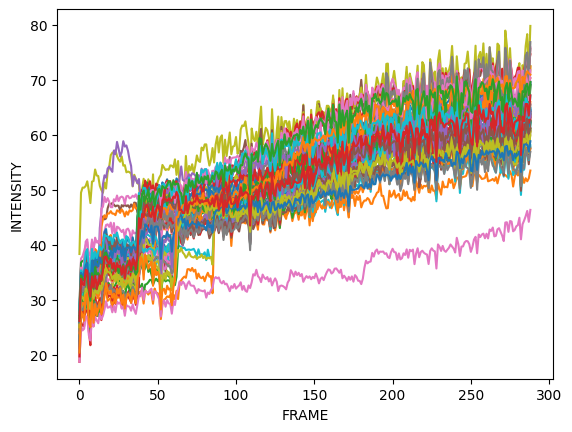

In [95]:
spore_ids = df_original["SPORE_ID"].unique()

for spore_id in spore_ids:
  spore_data = df_original[df_original["SPORE_ID"] == spore_id]
  germination_frame_row = spore_data.loc[spore_data["GERMINATION"] == 1]
  germination_frame = germination_frame_row["FRAME"].min()
  df_original.loc[df_original["SPORE_ID"] == spore_id, "GERMINATION_FRAME"] = germination_frame
  sns.lineplot(x = "FRAME", y = "INTENSITY", data = spore_data)

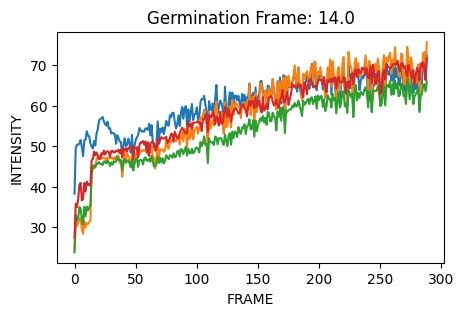

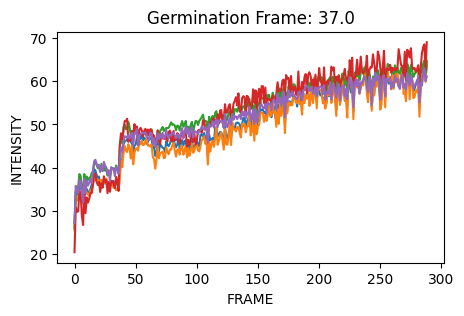

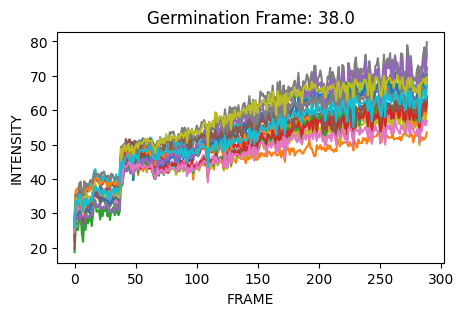

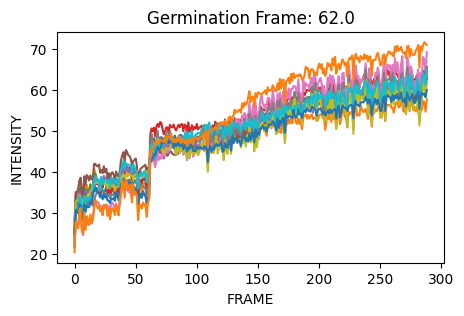

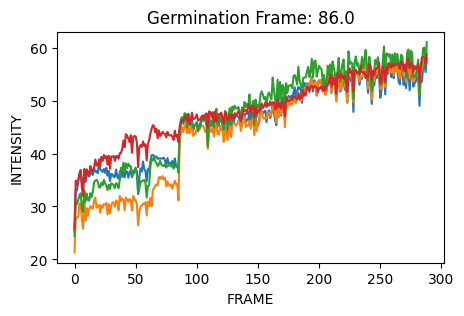

In [106]:
germination_groups = df_original.groupby("GERMINATION_FRAME")


for germination_frame, germination_group in germination_groups:
    spore_ids = germination_group["SPORE_ID"].unique()
    if len(spore_ids) > 3:
        plt.figure(figsize=(5, 3))  # Create a new figure
        for spore_id in spore_ids:
            spore_data = germination_group[germination_group["SPORE_ID"] == spore_id]
            sns.lineplot(x="FRAME", y="INTENSITY", data=spore_data)
        
        plt.title(f'Germination Frame: {germination_frame}')
        plt.show()  # Show the figure for this group